In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
from simple_attacks import SimpleAttack
attack = SimpleAttack()

In [3]:
enron_vec = pd.read_csv('data/enron_cleaned.csv')
enron_vec = enron_vec.fillna('')

In [4]:
bigram_vectorizer = CountVectorizer(ngram_range = (2, 2))
corpus_fitted = bigram_vectorizer.fit(enron_vec['clean_msg_no_lst'])
_, X_test, _, Y_test = train_test_split(enron_vec[['clean_msg_no_lst']], enron_vec.target, random_state = 42, test_size = 0.2)
X_test_fitted = corpus_fitted.transform(X_test['clean_msg_no_lst'])

In [5]:
with open('models/rf_pkl', 'rb') as f:
    rf = pickle.load(f)
    
with open('models/mbayes_pkl', 'rb') as f:
    mbayes = pickle.load(f)
    
with open('models/lr_pkl', 'rb') as f:
    lr = pickle.load(f)
    
with open('models/svm_pkl', 'rb') as f:
    svm_SVC = pickle.load(f)
    
with open('models/knn_pkl', 'rb') as f:
    knn = pickle.load(f)

# Pure Ham Attack

In [6]:
pure_ham_df = attack.dictionary_attack_pure_ham('Click here for this great price tinyurl.com/4kd8pwf3')
pure_ham_df.head()

,clean_msg_no_lst,target
0,Click here for this great price tinyurl.com/4k...,1
1,Click here for this great price tinyurl.com/4k...,1
2,Click here for this great price tinyurl.com/4k...,1
3,Click here for this great price tinyurl.com/4k...,1
4,Click here for this great price tinyurl.com/4k...,1


In [10]:
X_pure = corpus_fitted.transform(pure_ham_df['clean_msg_no_lst'])
Y_pure = pure_ham_df.target

### Random Forest

In [11]:
rf_predictions = rf.predict(X_pure)
print(rf_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Naive Bayes

In [12]:
mbayes_predictions = mbayes.predict(X_pure)
print(mbayes_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Logistic Regression

In [13]:
lr_predictions = lr.predict(X_pure)
print(lr_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### SVM

In [14]:
svm_predictions = svm_SVC.predict(X_pure)
print(svm_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### KNN

In [16]:
knn_predictions = knn.predict(X_pure)
print(knn_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Results
If spam is disguised as ham using purely ham keywords (besides the malicious tokens planted), no model is able to detect them as spam. One main reason is that they do not learn syntax, grammar, or context beyond the bigram.

# Injecting Ham Attack

In [6]:
test_attack = attack.dictionary_attack_from_spam()
X_test_attack = test_attack['clean_msg_no_lst']
Y_test_attack = test_attack['target']
X_test_attack_fitted = corpus_fitted.transform(X_test_attack)
test_attack.head()

,clean_msg_no_lst,target
23615,read holding floor meeting following date join...,0
7794,wanted submit notice rotation fundamental anal...,0
12369,gtv project status weekly update attached file...,0
16937,received email requester specified manager cli...,0
14702,louise clarification hsr waiting period receiv...,0


### Random Forest

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3333
           1       0.93      0.99      0.96      3336

    accuracy                           0.96      6669
   macro avg       0.96      0.96      0.96      6669
weighted avg       0.96      0.96      0.96      6669

[[3102  231]
 [  32 3304]]


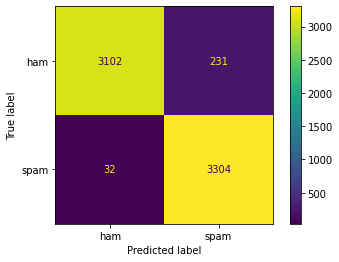

In [7]:
rf_predictions = rf.predict(X_test_fitted)
print(classification_report(Y_test, rf_predictions))
print(confusion_matrix(Y_test, rf_predictions))

cm_rf = confusion_matrix(Y_test, rf_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3333
           1       0.92      0.84      0.88      3336

    accuracy                           0.88      6669
   macro avg       0.89      0.88      0.88      6669
weighted avg       0.89      0.88      0.88      6669

[[3102  231]
 [ 549 2787]]


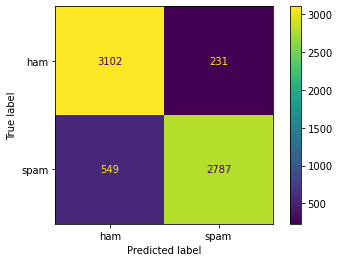

In [8]:
rf_predictions = rf.predict(X_test_attack_fitted)
print(classification_report(Y_test_attack, rf_predictions))
print(confusion_matrix(Y_test_attack, rf_predictions))

cm_rf = confusion_matrix(Y_test_attack, rf_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();

### Naive Bayes

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3333
           1       0.98      0.99      0.99      3336

    accuracy                           0.99      6669
   macro avg       0.99      0.99      0.99      6669
weighted avg       0.99      0.99      0.99      6669

[[3279   54]
 [  21 3315]]


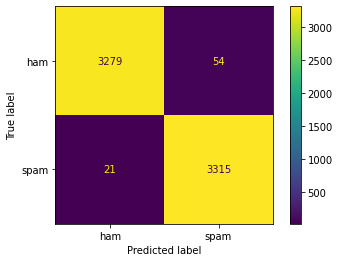

In [9]:
mbayes_predictions = mbayes.predict(X_test_fitted)
print(classification_report(Y_test, mbayes_predictions))
print(confusion_matrix(Y_test, mbayes_predictions))

cm_mbayes = confusion_matrix(Y_test, mbayes_predictions)
cmd_mbayes = ConfusionMatrixDisplay(cm_mbayes, display_labels=['ham','spam'])
cmd_mbayes.plot();

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      3333
           1       0.98      0.84      0.90      3336

    accuracy                           0.91      6669
   macro avg       0.92      0.91      0.91      6669
weighted avg       0.92      0.91      0.91      6669

[[3279   54]
 [ 540 2796]]


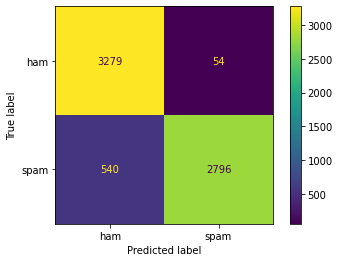

In [10]:
mbayes_predictions = mbayes.predict(X_test_attack_fitted)
print(classification_report(Y_test_attack, mbayes_predictions))
print(confusion_matrix(Y_test_attack, mbayes_predictions))

cm_rf = confusion_matrix(Y_test_attack, mbayes_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();

### 7.3 Logistic Regression

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3333
           1       0.96      0.99      0.98      3336

    accuracy                           0.98      6669
   macro avg       0.98      0.98      0.98      6669
weighted avg       0.98      0.98      0.98      6669

[[3191  142]
 [  22 3314]]


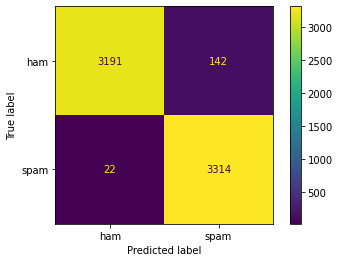

In [11]:
lr_predictions = lr.predict(X_test_fitted)
print(classification_report(Y_test, lr_predictions))
print(confusion_matrix(Y_test, lr_predictions))

cm_lr = confusion_matrix(Y_test, lr_predictions)
cmd_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['ham','spam'])
cmd_lr.plot();

              precision    recall  f1-score   support

           0       0.86      0.96      0.90      3333
           1       0.95      0.84      0.89      3336

    accuracy                           0.90      6669
   macro avg       0.90      0.90      0.90      6669
weighted avg       0.90      0.90      0.90      6669

[[3191  142]
 [ 540 2796]]


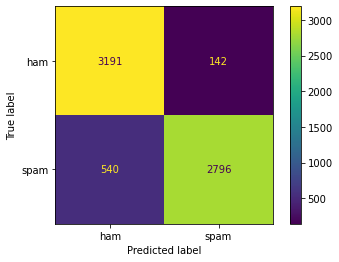

In [12]:
lr_predictions = lr.predict(X_test_attack_fitted)
print(classification_report(Y_test_attack, lr_predictions))
print(confusion_matrix(Y_test_attack, lr_predictions))

cm_rf = confusion_matrix(Y_test_attack, lr_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();

### SVM

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      3333
           1       0.90      0.95      0.93      3336

    accuracy                           0.92      6669
   macro avg       0.93      0.92      0.92      6669
weighted avg       0.93      0.92      0.92      6669

[[2986  347]
 [ 155 3181]]


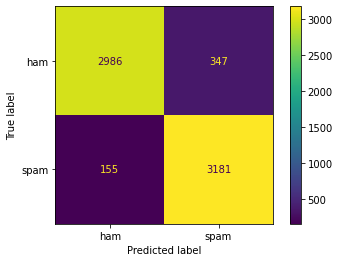

In [13]:
svm_SVC_predictions = svm_SVC.predict(X_test_fitted)
print(classification_report(Y_test, svm_SVC_predictions))
print(confusion_matrix(Y_test, svm_SVC_predictions))

cm_svm = confusion_matrix(Y_test, svm_SVC_predictions)
cmd_svm = ConfusionMatrixDisplay(cm_svm, display_labels=['ham','spam'])
cmd_svm.plot();

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3333
           1       0.89      0.80      0.84      3336

    accuracy                           0.85      6669
   macro avg       0.85      0.85      0.85      6669
weighted avg       0.85      0.85      0.85      6669

[[2986  347]
 [ 651 2685]]


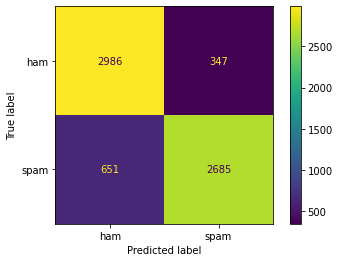

In [14]:
svm_SVC_predictions = svm_SVC.predict(X_test_attack_fitted)
print(classification_report(Y_test_attack, svm_SVC_predictions))
print(confusion_matrix(Y_test_attack, svm_SVC_predictions))

cm_rf = confusion_matrix(Y_test_attack, svm_SVC_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();

### KNN

[[3323   10]
 [1256 2080]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      3333
           1       1.00      0.62      0.77      3336

    accuracy                           0.81      6669
   macro avg       0.86      0.81      0.80      6669
weighted avg       0.86      0.81      0.80      6669



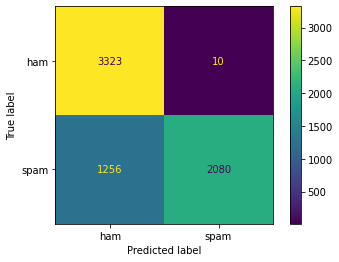

In [15]:
knn_predictions = knn.predict(X_test_fitted)
print(confusion_matrix(Y_test, knn_predictions))
print(classification_report(Y_test, knn_predictions))

cm_knn = confusion_matrix(Y_test, knn_predictions)
cmd_knn = ConfusionMatrixDisplay(cm_knn, display_labels=['ham','spam'])
cmd_knn.plot();

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      3333
           1       0.99      0.53      0.69      3336

    accuracy                           0.76      6669
   macro avg       0.84      0.76      0.75      6669
weighted avg       0.84      0.76      0.75      6669

[[3323   10]
 [1579 1757]]


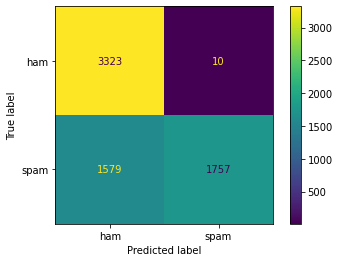

In [16]:
knn_predictions = knn.predict(X_test_attack_fitted)
print(classification_report(Y_test_attack, knn_predictions))
print(confusion_matrix(Y_test_attack, knn_predictions))

cm_rf = confusion_matrix(Y_test_attack, knn_predictions)
cmd_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['ham','spam'])
cmd_rf.plot();